In [1]:
# load model
from ecgclassifier_model import ECGClassifier
from random import randint
from matplotlib import pyplot as plt

model_path = "lightning_logs/ecg_clf/version_3/checkpoints/ecg-clf-best-epoch=12-acc=0.9677.ckpt"
model = ECGClassifier.load_from_checkpoint(model_path)

## 1. Model and Dataset Loading

In [2]:
from dataset import ECGDataset, DatasetWithTransform
import albumentations as A

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet stats
    A.pytorch.ToTensorV2()
])

DATA_ROOT_DIR = '../../datasets/ecg/gwbz3fsgp8-2/'
ecg_dataset = DatasetWithTransform(ECGDataset(root_dir=DATA_ROOT_DIR, crop=(70, 285, 2175, 1517)),
                                   transform=val_test_transform)
ecg_dataset[0][0].shape

torch.Size([3, 224, 224])

## 2. Utility Functions

In [3]:
# invert the normalization for visualization
from contextlib import contextmanager
import numpy as np
from PIL import Image
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt
from math import ceil
import os


def inverse_transform(image: np.ndarray) -> Image.Image:
    """Inverse the normalization transform."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inv_image = image * std + mean
    inv_image = np.clip(inv_image, 0, 1)
    return Image.fromarray((inv_image * 255).astype(np.uint8))


@contextmanager
def disable_tqdm():
    from unittest.mock import patch
    with patch('tqdm.tqdm', side_effect=lambda iterable, *args, **kwargs: iterable):
        yield
        pass


# XAI (Explainable Artificial Intelligence) validation

Check if the highlighted regions correspond to clinically relevant ECG features using proper techniques for that:
- Technique 1: Correlate highlighted regions with known ECG landmarks (P wave, QRS complex, T wave)
- Technique 2: Faithful perturbation tests (masking important regions and observing prediction changes)

In [15]:
import torch
import torch.nn.functional as F
from typing import Callable, List, Tuple
import scipy.ndimage as ndimage


def perturbation_test(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    grayscale_cam: np.ndarray,
    threshold: float = 0.5,
    baseline: str = 'mean'
) -> dict:
    """
    Test model faithfulness by masking important regions.

    Args:
        model: The classifier model
        input_tensor: Input image tensor (1, C, H, W)
        grayscale_cam: GradCAM heatmap
        threshold: Threshold for important regions
        baseline: 'mean', 'zero', or 'blur' for replacement strategy

    Returns:
        Dictionary with prediction changes
    """
    model.eval()

    # Original prediction
    with torch.no_grad():
        orig_output = model(input_tensor.to(device=model.device))
        orig_probs = F.softmax(orig_output, dim=1)
        orig_pred = torch.argmax(orig_probs, dim=1).item()
        orig_conf = orig_probs[0, orig_pred].item()

    # Resize CAM to input size
    cam_resized = torch.from_numpy(
        ndimage.zoom(grayscale_cam,
                     (input_tensor.shape[2] / grayscale_cam.shape[0],
                      input_tensor.shape[3] / grayscale_cam.shape[1]),
                     order=1)
    )

    # Create mask for important regions
    important_mask = (cam_resized > threshold).float()

    # Create perturbed input
    perturbed = input_tensor.clone()

    if baseline == 'mean':
        replacement = input_tensor.mean(dim=[2, 3], keepdim=True)
    elif baseline == 'zero':
        replacement = torch.zeros_like(input_tensor)
    elif baseline == 'blur':
        replacement = torch.from_numpy(
            ndimage.gaussian_filter(input_tensor[0].numpy(), sigma=[0, 3, 3])
        ).unsqueeze(0)

    # Mask important regions
    for c in range(perturbed.shape[1]):
        perturbed[0, c] = perturbed[0, c] * (1 - important_mask) + replacement[0, c] * important_mask

    # Perturbed prediction
    with torch.no_grad():
        pert_output = model(perturbed.to(device=model.device))
        pert_probs = F.softmax(pert_output, dim=1)
        pert_pred = torch.argmax(pert_probs, dim=1).item()
        pert_conf = pert_probs[0, orig_pred].item()

    return {
        'original_prediction': orig_pred,
        'original_confidence': orig_conf,
        'perturbed_prediction': pert_pred,
        'perturbed_confidence': pert_conf,
        'confidence_drop': orig_conf - pert_conf,
        'prediction_changed': orig_pred != pert_pred
    }


def insertion_curve(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    grayscale_cam: np.ndarray,
    steps: int = 20,
    orig_pred: int | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute insertion curve for faithfulness evaluation.

    Start with baseline, progressively reveal important pixels.
    Higher AUC = better (model relies on important regions)

    Args:
        model: The classifier model
        input_tensor: Input image tensor (1, C, H, W)
        grayscale_cam: GradCAM heatmap
        steps: Number of steps for perturbation
        orig_pred: Original prediction class index (if None, computed inside)

    Returns:
        Tuple of (x_axis, insertion_scores)
    """
    model.eval()

    if orig_pred is None:
        # Get original prediction (computed once)
        with torch.no_grad():
            orig_output = model(input_tensor.to(device=model.device))
            orig_pred = torch.argmax(orig_output, dim=1).item()

    # Resize CAM
    cam_resized = ndimage.zoom(
        grayscale_cam,
        (input_tensor.shape[2] / grayscale_cam.shape[0],
         input_tensor.shape[3] / grayscale_cam.shape[1]),
        order=1
    )

    # Get pixel importance order
    flat_cam = cam_resized.flatten()
    sorted_indices = np.argsort(flat_cam)[::-1]  # Most important first

    insertion_scores = []
    baseline = input_tensor.mean(dim=[2, 3], keepdim=True)

    for step in range(steps + 1):
        n_pixels = int((step / steps) * len(sorted_indices))

        # Insertion: start with baseline, reveal important pixels
        insertion_img = baseline.repeat(1, 1, input_tensor.shape[2], input_tensor.shape[3])
        if n_pixels > 0:
            pixels_to_reveal = sorted_indices[:n_pixels]
            for idx in pixels_to_reveal:
                i, j = np.unravel_index(idx, cam_resized.shape)
                insertion_img[0, :, i, j] = input_tensor[0, :, i, j]

        # Get prediction
        with torch.no_grad():
            ins_output = model(insertion_img.to(device=model.device))
            ins_prob = F.softmax(ins_output, dim=1)[0, orig_pred].item()
            insertion_scores.append(ins_prob)

    x_axis = np.linspace(0, 1, steps + 1)
    return x_axis, np.array(insertion_scores)


def deletion_curve(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    grayscale_cam: np.ndarray,
    steps: int = 20,
    orig_pred: int | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute deletion curve for faithfulness evaluation.

    Start with original image, progressively delete important pixels.
    Lower AUC = better (model confidence drops when important regions removed)

    Args:
        model: The classifier model
        input_tensor: Input image tensor (1, C, H, W)
        grayscale_cam: GradCAM heatmap
        steps: Number of steps for perturbation
        orig_pred: Original prediction class index (if None, computed inside)

    Returns:
        Tuple of (x_axis, deletion_scores)
    """
    model.eval()

    if orig_pred is None:
        # Get original prediction (computed once)
        with torch.no_grad():
            orig_output = model(input_tensor.to(device=model.device))
            orig_pred = torch.argmax(orig_output, dim=1).item()

    # Resize CAM
    cam_resized = ndimage.zoom(
        grayscale_cam,
        (input_tensor.shape[2] / grayscale_cam.shape[0],
         input_tensor.shape[3] / grayscale_cam.shape[1]),
        order=1
    )

    # Get pixel importance order
    flat_cam = cam_resized.flatten()
    sorted_indices = np.argsort(flat_cam)[::-1]  # Most important first

    deletion_scores = []
    baseline = input_tensor.mean(dim=[2, 3], keepdim=True)

    for step in range(steps + 1):
        n_pixels = int((step / steps) * len(sorted_indices))

        # Deletion: start with original, delete important pixels
        deletion_img = input_tensor.clone()
        if n_pixels > 0:
            pixels_to_delete = sorted_indices[:n_pixels]
            for idx in pixels_to_delete:
                i, j = np.unravel_index(idx, cam_resized.shape)
                deletion_img[0, :, i, j] = baseline[0, :, 0, 0]

        # Get prediction
        with torch.no_grad():
            del_output = model(deletion_img.to(device=model.device))
            del_prob = F.softmax(del_output, dim=1)[0, orig_pred].item()
            deletion_scores.append(del_prob)

    x_axis = np.linspace(0, 1, steps + 1)
    return x_axis, np.array(deletion_scores)


def insertion_deletion_curves(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    grayscale_cam: np.ndarray,
    steps: int = 20
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute insertion and deletion curves for faithfulness evaluation.

    Higher AUC for insertion = better
    Lower AUC for deletion = better

    Args:
        model: The classifier model
        input_tensor: Input image tensor (1, C, H, W)
        grayscale_cam: GradCAM heatmap
        steps: Number of steps for perturbation

    Returns:
        Tuple of (x_axis, insertion_scores, deletion_scores)
    """
    model.eval()

    # Get original prediction (computed once)
    with torch.no_grad():
        orig_output = model(input_tensor.to(device=model.device))
        orig_pred = torch.argmax(orig_output, dim=1).item()

    # Compute both curves with the same orig_pred
    x_axis, insertion_scores = insertion_curve(model, input_tensor, grayscale_cam, steps=steps, orig_pred=orig_pred)
    _, deletion_scores = deletion_curve(model, input_tensor, grayscale_cam, steps=steps, orig_pred=orig_pred)

    return x_axis, insertion_scores, deletion_scores


def sanity_check_randomization(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    cam_method: Callable,
    target_layers: List,
    n_trials: int = 5
) -> dict:
    """
    Sanity check: CAM should change significantly when model weights are randomized.
    Based on Adebayo et al. 2018 "Sanity Checks for Saliency Maps"
    """
    # Get original CAM
    with cam_method(model=model, target_layers=target_layers) as cam:
        original_cam = cam(input_tensor=input_tensor, targets=None)[0]

    # Progressively randomize layers and measure CAM change
    randomized_similarities = []

    for trial in range(n_trials):
        # Create a copy and randomize last layers
        model_copy = type(model).load_from_checkpoint(
            model_path,
            num_classes=model.num_classes,
            learning_rate=model.learning_rate
        )

        # Randomize the final layers
        layers_to_randomize = [model_copy.backbone.layer4, model_copy.backbone.fc]
        for layer in layers_to_randomize[:trial + 1]:
            if hasattr(layer, 'weight'):
                torch.nn.init.normal_(layer.weight)
            if hasattr(layer, 'bias') and layer.bias is not None:
                torch.nn.init.normal_(layer.bias)

        # Get CAM from randomized model
        with cam_method(model=model_copy, target_layers=target_layers) as cam:
            randomized_cam = cam(input_tensor=input_tensor, targets=None)[0]

        # Compute similarity (should decrease)
        similarity = np.corrcoef(original_cam.flatten(), randomized_cam.flatten())[0, 1]
        randomized_similarities.append(similarity)

    return {
        'similarities': randomized_similarities,
        'mean_similarity': np.mean(randomized_similarities),
        'passes_sanity_check': np.mean(randomized_similarities) < 0.5
    }

## XAI Validation: Simple Techniques

### 1. Perturbation Test
This test validates if the regions highlighted by GradCAM are actually important for the model's decision.

100%|██████████| 32/32 [00:00<00:00, 105.04it/s]


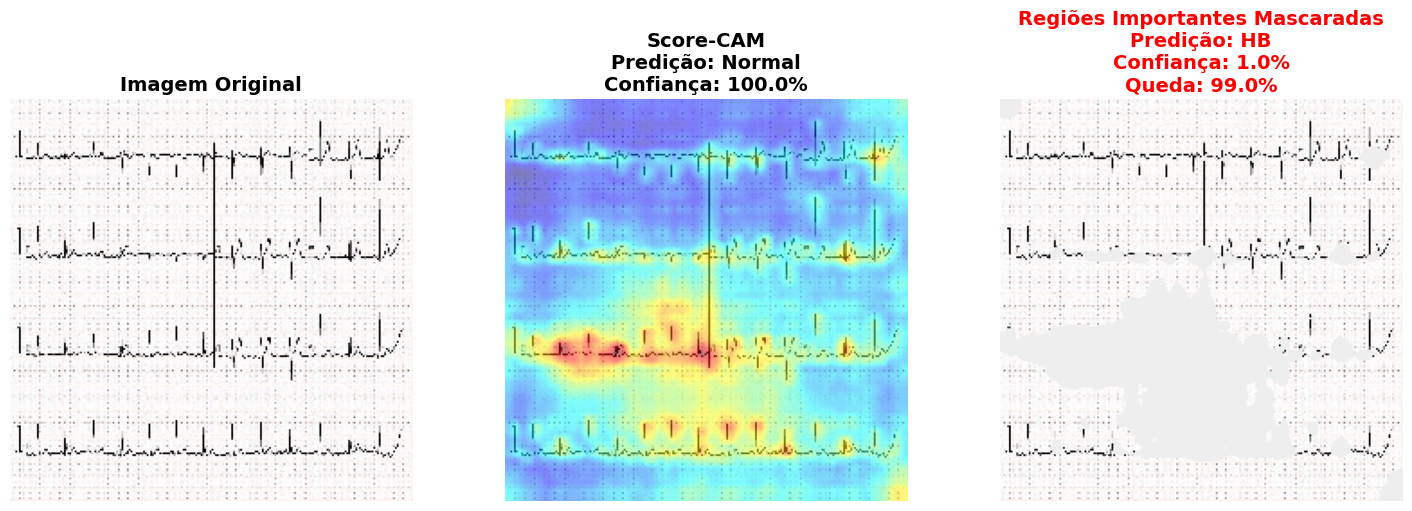

✓ Resultados do Teste de Perturbação:
  Queda de Confiança: 99.02%
  Predição Alterada: True
  APROVADO: Regiões importantes causaram queda significativa de confiança


In [5]:
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]

rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0

model.cuda()
target_layers = [model.backbone.layer1[-1], model.backbone.layer3[-1], model.backbone.layer4[-1]]
with ScoreCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

thr = 0.5
pert_results = perturbation_test(model, input_tensor, grayscale_cam, threshold=thr, baseline='mean')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_img)
axes[0].set_title('Imagem Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(visualization)
axes[1].set_title(f'Score-CAM\nPredição: {ecg_dataset.dataset.classes[pert_results["original_prediction"]]}\n'
                  f'Confiança: {pert_results["original_confidence"]:.1%}',
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

cam_resized = ndimage.zoom(grayscale_cam, 
                           (rgb_img.shape[0] / grayscale_cam.shape[0],
                            rgb_img.shape[1] / grayscale_cam.shape[1]),
                           order=1)
important_mask = cam_resized > thr
perturbed_vis = rgb_img.copy()
perturbed_vis[important_mask] = rgb_img.mean()

axes[2].imshow(perturbed_vis)
axes[2].set_title(f'Regiões Importantes Mascaradas\nPredição: {ecg_dataset.dataset.classes[pert_results["perturbed_prediction"]]}\n'
                  f'Confiança: {pert_results["perturbed_confidence"]:.1%}\n'
                  f'Queda: {pert_results["confidence_drop"]:.1%}',
                  fontsize=14, fontweight='bold',
                  color='red' if pert_results['prediction_changed'] else 'green')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('../texto/figuras/teste_perturbacao_exemplo.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Resultados do Teste de Perturbação:")
print(f"  Queda de Confiança: {pert_results['confidence_drop']:.2%}")
print(f"  Predição Alterada: {pert_results['prediction_changed']}")
print(f"  {'APROVADO' if pert_results['confidence_drop'] > 0.1 else 'REPROVADO'}: "
      f"Regiões importantes causaram queda {'significativa' if pert_results['confidence_drop'] > 0.1 else 'insignificante'} de confiança")

### Comprehensive Perturbation Statistics for All Samples

Compute perturbation statistics across the entire dataset and save results for further analysis.

In [6]:
# Compute perturbation statistics for all samples in the dataset
import os
from tqdm.auto import tqdm
import pandas as pd

print(f"Computing perturbation statistics for all {len(ecg_dataset)} samples...")

thresholds = [0.4, 0.5, 0.6, 0.7]

# Initialize results storage
all_perturbation_results = []

# Ensure model is on GPU
model.cuda()
target_layers = [model.backbone.layer1[-1], model.backbone.layer4[-1]]

# Process all samples
for idx in tqdm(range(len(ecg_dataset)), desc="Processing samples"):
    input_tensor = ecg_dataset[idx][0].unsqueeze(0)
    true_label = ecg_dataset[idx][1]
    
    # Get filename
    filename = os.path.basename(ecg_dataset.dataset.image_paths[idx])
    
    # Generate GradCAM
    with disable_tqdm():
        with ScoreCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)
            grayscale_cam = grayscale_cam[0, :]
    
    # Run perturbation test with multiple thresholds
    for threshold in thresholds:
        pert_results = perturbation_test(
            model, input_tensor, grayscale_cam, 
            threshold=threshold, baseline='mean'
        )
        
        # Store results
        all_perturbation_results.append({
            'sample_idx': idx,
            'filename': filename,
            'true_label': true_label,
            'true_class': ecg_dataset.dataset.classes[true_label],
            'threshold': threshold,
            'original_prediction': pert_results['original_prediction'],
            'original_class': ecg_dataset.dataset.classes[pert_results['original_prediction']],
            'original_confidence': pert_results['original_confidence'],
            'perturbed_prediction': pert_results['perturbed_prediction'],
            'perturbed_class': ecg_dataset.dataset.classes[pert_results['perturbed_prediction']],
            'perturbed_confidence': pert_results['perturbed_confidence'],
            'confidence_drop': pert_results['confidence_drop'],
            'prediction_changed': pert_results['prediction_changed'],
            'originally_correct': pert_results['original_prediction'] == true_label
        })

# Create DataFrame
df_perturbation = pd.DataFrame(all_perturbation_results)

# Save to CSV
output_dir = '../results/xai_validation'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'perturbation_statistics_all_samples.csv')
df_perturbation.to_csv(output_file, index=False)

print(f"\n✓ Perturbation statistics saved to: {output_file}")
print(f"  Total samples: {len(df_perturbation) // len(thresholds)}")  # Divided by number of thresholds
print(f"  Unique samples: {df_perturbation['sample_idx'].nunique()}")
print(f"  Thresholds tested: {df_perturbation['threshold'].unique()}")

# Display summary
print(f"\n{'='*70}")
print("PERTURBATION STATISTICS SUMMARY")
print(f"{'='*70}")
df_perturbation.groupby('threshold').agg({
    'confidence_drop': ['mean', 'std', 'median', 'min', 'max'],
    'prediction_changed': 'mean'
}).round(3)

Computing perturbation statistics for all 928 samples...


Processing samples:   0%|          | 0/928 [00:00<?, ?it/s]


✓ Perturbation statistics saved to: ../results/xai_validation/perturbation_statistics_all_samples.csv
  Total samples: 928
  Unique samples: 928
  Thresholds tested: [0.4 0.5 0.6 0.7]

PERTURBATION STATISTICS SUMMARY


confidence_drop                             prediction_changed
                     mean    std median    min    max               mean
threshold                                                               
0.4                 0.692  0.391  0.928  0.001  0.999              0.714
0.5                 0.577  0.390  0.744  0.001  1.000              0.584
0.6                 0.332  0.360  0.170 -0.101  0.996              0.298
0.7                 0.131  0.223  0.013 -0.068  0.988              0.085

### Detailed Analysis by Class and Threshold

/tmp/ipykernel_347004/2297390138.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=['Corretas', 'Incorretas'], patch_artist=True)


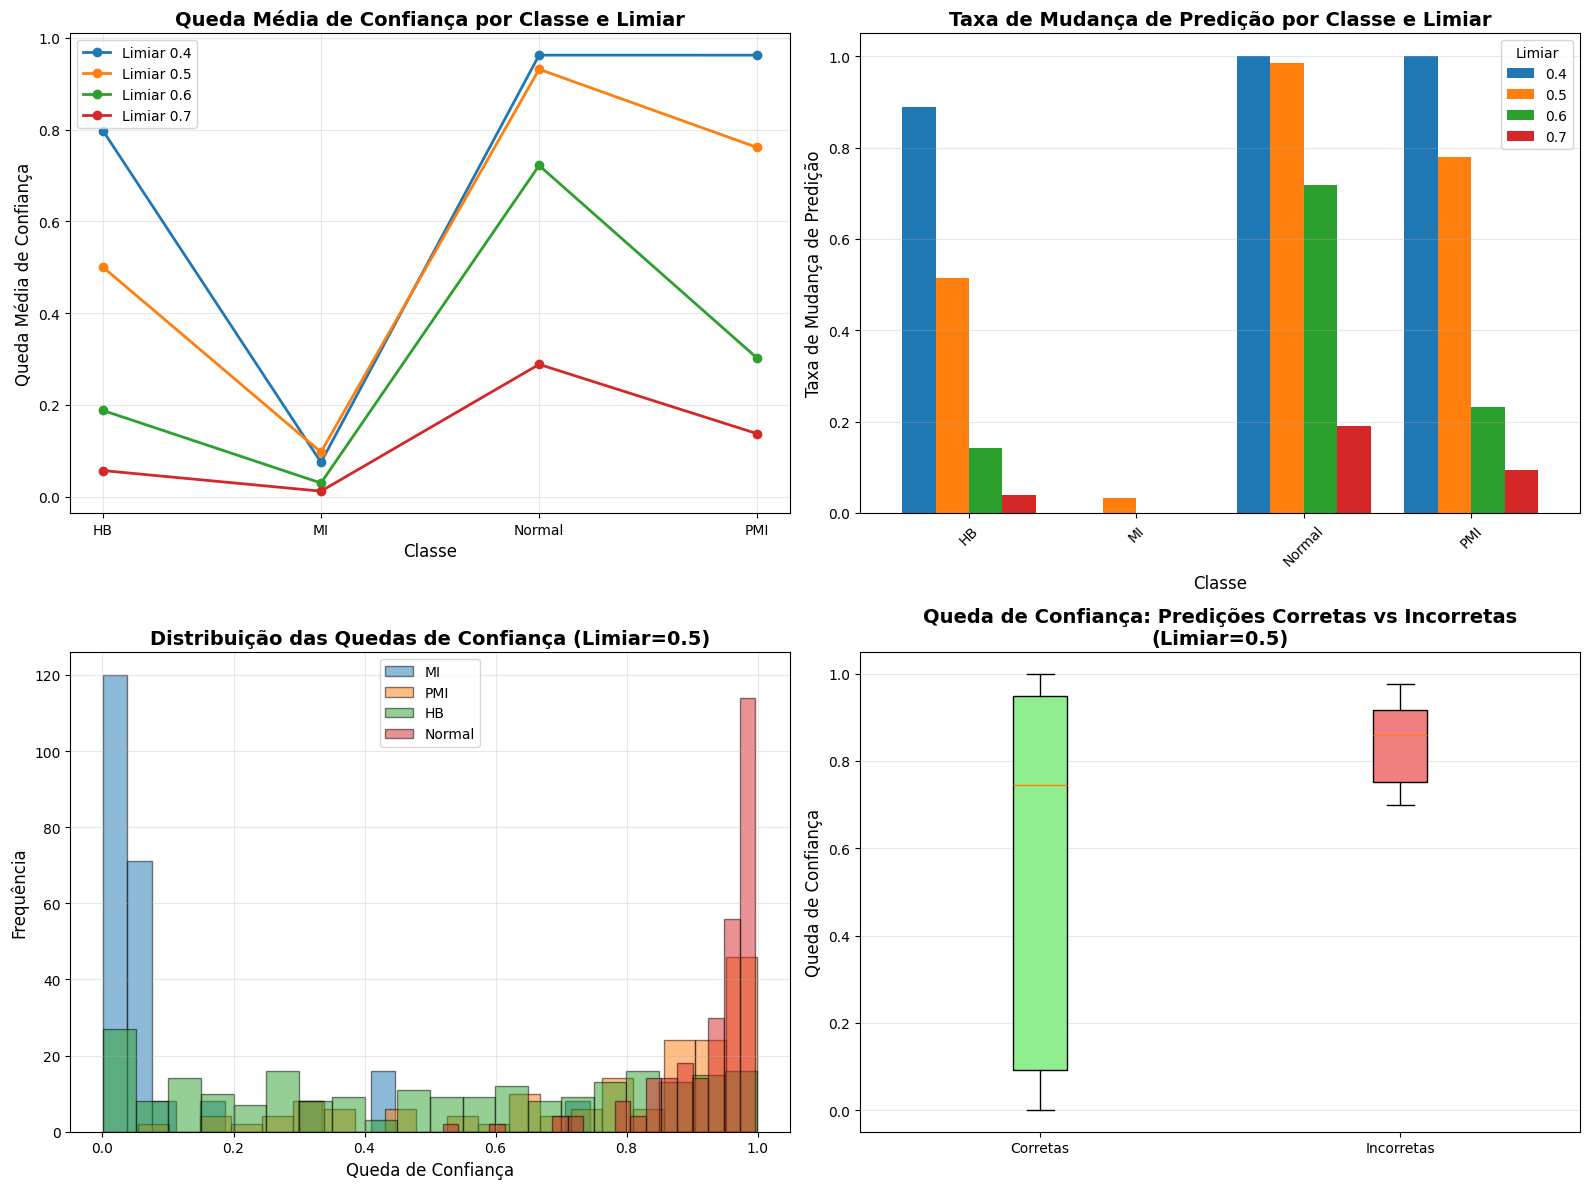


✓ Figura salva em: ../texto/figuras/analise_perturbacao_completa.png


In [7]:
import os
os.makedirs('../texto/figuras/', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Queda de confiança por classe e limiar
for threshold in df_perturbation['threshold'].unique():
    df_thresh = df_perturbation[df_perturbation['threshold'] == threshold]
    class_means = df_thresh.groupby('true_class')['confidence_drop'].mean()
    axes[0, 0].plot(class_means.index, class_means.values, 
                    marker='o', linewidth=2, label=f'Limiar {threshold}')

axes[0, 0].set_xlabel('Classe', fontsize=12)
axes[0, 0].set_ylabel('Queda Média de Confiança', fontsize=12)
axes[0, 0].set_title('Queda Média de Confiança por Classe e Limiar', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Taxa de mudança de predição por classe e limiar
pivot_change = df_perturbation.pivot_table(
    values='prediction_changed',
    index='true_class',
    columns='threshold',
    aggfunc='mean'
)
pivot_change.plot(kind='bar', ax=axes[0, 1], rot=45, width=0.8)
axes[0, 1].set_xlabel('Classe', fontsize=12)
axes[0, 1].set_ylabel('Taxa de Mudança de Predição', fontsize=12)
axes[0, 1].set_title('Taxa de Mudança de Predição por Classe e Limiar',
                     fontsize=14, fontweight='bold')
axes[0, 1].legend(title='Limiar')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Distribuição das quedas de confiança para limiar=0.5
df_05 = df_perturbation[df_perturbation['threshold'] == 0.5]
for class_name in df_05['true_class'].unique():
    class_data = df_05[df_05['true_class'] == class_name]['confidence_drop']
    axes[1, 0].hist(class_data, bins=20, alpha=0.5, label=class_name, edgecolor='black')

axes[1, 0].set_xlabel('Queda de Confiança', fontsize=12)
axes[1, 0].set_ylabel('Frequência', fontsize=12)
axes[1, 0].set_title('Distribuição das Quedas de Confiança (Limiar=0.5)',
                     fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Predições corretas vs incorretas
df_05_correct = df_05[df_05['originally_correct'] == True]['confidence_drop']
df_05_incorrect = df_05[df_05['originally_correct'] == False]['confidence_drop']

box_data = [df_05_correct, df_05_incorrect]
bp = axes[1, 1].boxplot(box_data, labels=['Corretas', 'Incorretas'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')

axes[1, 1].set_ylabel('Queda de Confiança', fontsize=12)
axes[1, 1].set_title('Queda de Confiança: Predições Corretas vs Incorretas\n(Limiar=0.5)',
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../texto/figuras/analise_perturbacao_completa.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figura salva em: ../texto/figuras/analise_perturbacao_completa.png")

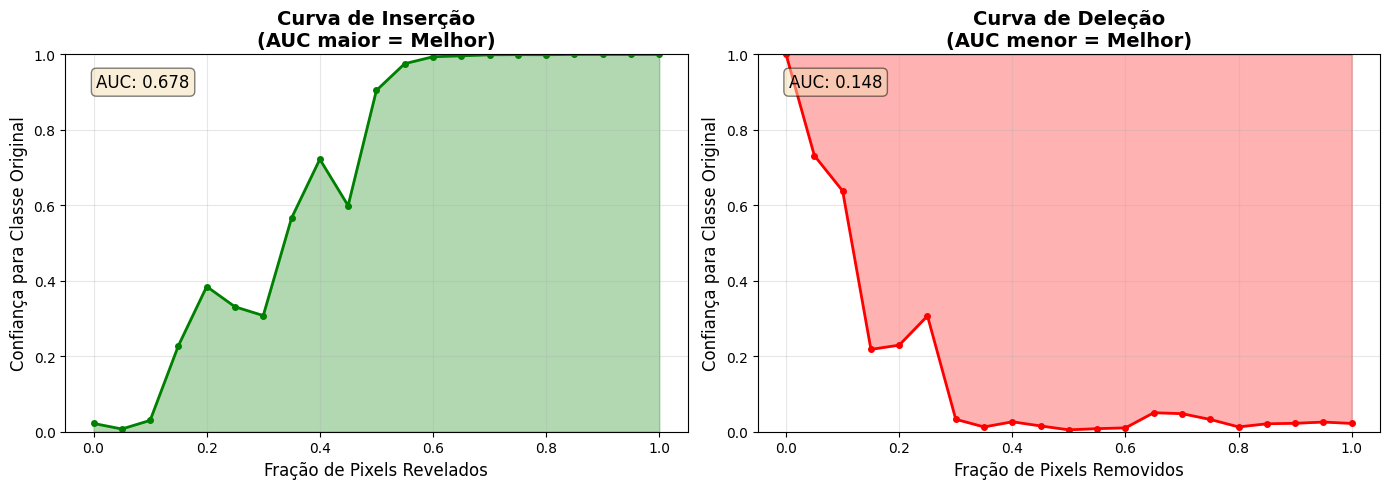

✓ Métricas de Fidelidade:
  AUC Inserção: 0.678 (maior é melhor)
  AUC Deleção: 0.148 (menor é melhor)
  APROVADO: CAM destaca regiões fiéis


In [19]:
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]

x_axis, insertion_scores, deletion_scores = insertion_deletion_curves(
    model, input_tensor, grayscale_cam, steps=20
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curva de inserção
axes[0].plot(x_axis, insertion_scores, 'g-', linewidth=2, marker='o', markersize=4)
axes[0].fill_between(x_axis, 0, insertion_scores, alpha=0.3, color='green')
axes[0].set_xlabel('Fração de Pixels Revelados', fontsize=12)
axes[0].set_ylabel('Confiança para Classe Original', fontsize=12)
axes[0].set_title('Curva de Inserção\n(AUC maior = Melhor)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])
insertion_auc = np.trapz(insertion_scores, x_axis)
axes[0].text(0.05, 0.95, f'AUC: {insertion_auc:.3f}', 
             transform=axes[0].transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Curva de deleção
axes[1].plot(x_axis, deletion_scores, 'r-', linewidth=2, marker='o', markersize=4)
axes[1].fill_between(x_axis, deletion_scores, 1, alpha=0.3, color='red')
axes[1].set_xlabel('Fração de Pixels Removidos', fontsize=12)
axes[1].set_ylabel('Confiança para Classe Original', fontsize=12)
axes[1].set_title('Curva de Deleção\n(AUC menor = Melhor)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])
deletion_auc = np.trapz(deletion_scores, x_axis)
axes[1].text(0.05, 0.95, f'AUC: {deletion_auc:.3f}', 
             transform=axes[1].transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../texto/figuras/curvas_insercao_delecao.png', dpi=300, bbox_inches='tight')
plt.show()

is_good = insertion_auc > 0.5 and deletion_auc < 0.5
print(f"✓ Métricas de Fidelidade:")
print(f"  AUC Inserção: {insertion_auc:.3f} (maior é melhor)")
print(f"  AUC Deleção: {deletion_auc:.3f} (menor é melhor)")
print(f"  {'APROVADO' if is_good else 'REVISAR'}: "
      f"CAM destaca regiões {'fiéis' if is_good else 'potencialmente infiéis'}")

In [14]:
# Statistical validation across multiple samples
n_samples = len(ecg_dataset)
np.random.seed(42)

validation_results = {
    'sample_names': [],
    'confidence_drops': [],
    'insertion_aucs': [],
    'deletion_aucs': [],
    'prediction_changes': [],
    'labels_names': []
}

print(f"Running statistical validation on {n_samples} samples...")

samples_to_validate = np.random.choice(len(ecg_dataset), size=n_samples, replace=False)

for i in tqdm(range(n_samples)):
    idx = samples_to_validate[i]
    input_tensor = ecg_dataset[idx][0].unsqueeze(0)
    validation_results['sample_names'].append(os.path.basename(ecg_dataset.dataset.image_paths[idx]))
    validation_results['labels_names'].append(ecg_dataset.dataset.classes[ecg_dataset[idx][1]])
    
    # Generate CAM
    with disable_tqdm():
        with ScoreCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]
    
    # Perturbation test
    pert_res = perturbation_test(model, input_tensor, grayscale_cam, threshold=0.5)
    validation_results['confidence_drops'].append(pert_res['confidence_drop'])
    validation_results['prediction_changes'].append(pert_res['prediction_changed'])
    
    # Insertion/Deletion
    _, ins_scores, del_scores = insertion_deletion_curves(model, input_tensor, grayscale_cam, steps=10)
    x = np.linspace(0, 1, len(ins_scores))
    validation_results['insertion_aucs'].append(np.trapz(ins_scores, x))
    validation_results['deletion_aucs'].append(np.trapz(del_scores, x))

# save results to DataFrame
validation_results = pd.DataFrame(validation_results)
validation_results['auc_max'] = np.maximum((1-validation_results['deletion_aucs']).values,validation_results['insertion_aucs'].values)
output_file = os.path.join(output_dir, 'statistical_validation_results.csv')
validation_results.to_csv(output_file, index=False)
print(f"\n✓ Statistical validation results saved to: {output_file}")

Running statistical validation on 928 samples...


  0%|          | 0/928 [00:00<?, ?it/s]


✓ Statistical validation results saved to: ../results/xai_validation/statistical_validation_results.csv


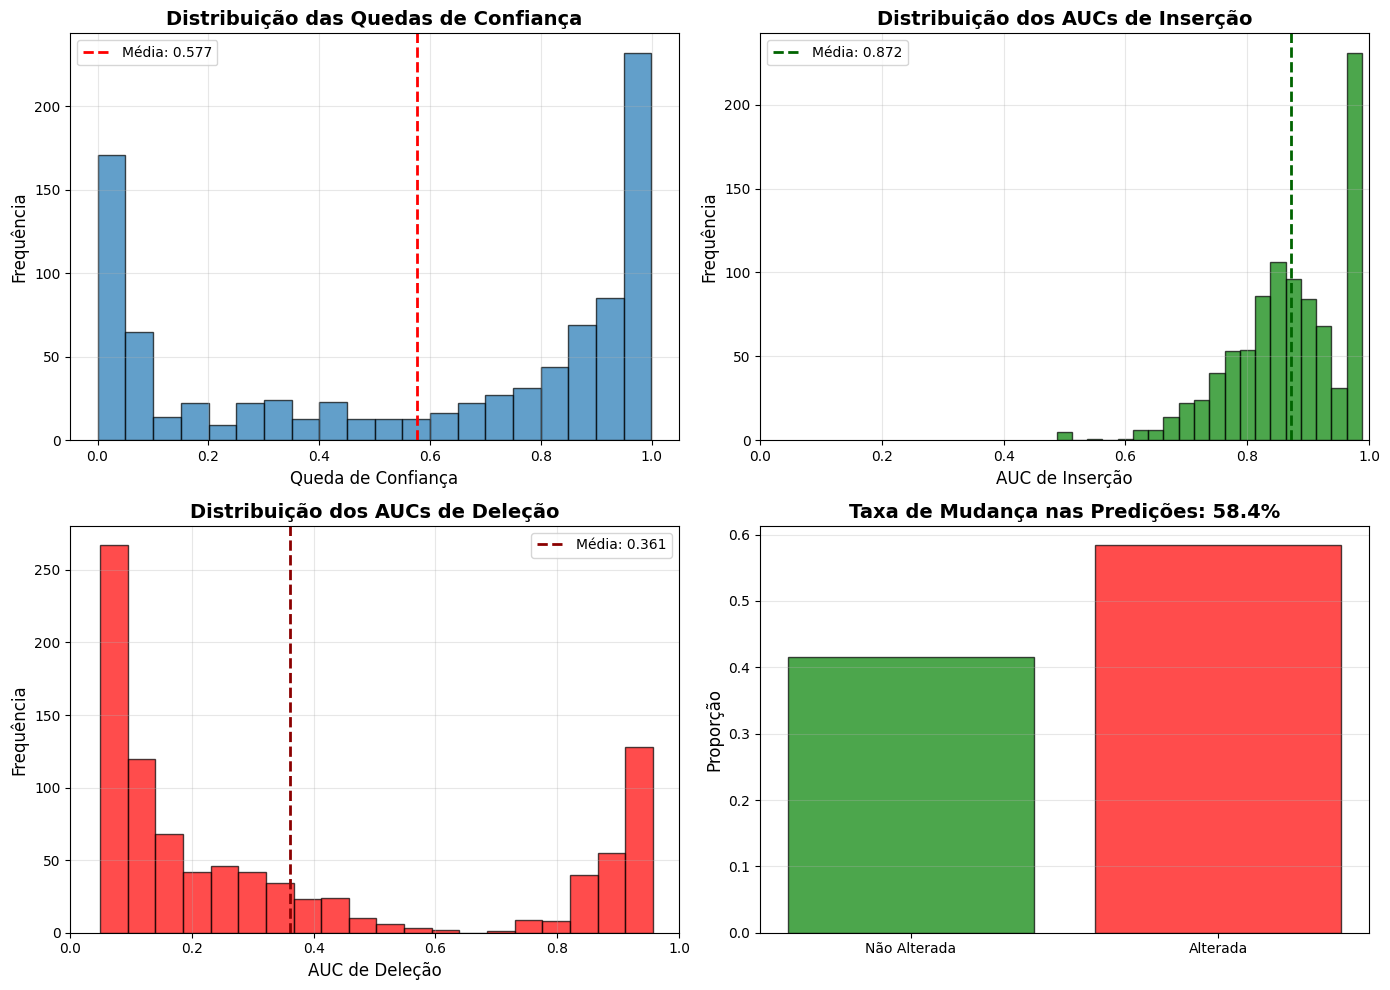

       confidence_drops  insertion_aucs  deletion_aucs  auc_max
count           928.000         928.000        928.000  928.000
mean              0.577           0.872          0.361    0.917
std               0.390           0.095          0.335    0.058
min               0.001           0.487          0.049    0.655
25%               0.091           0.815          0.086    0.892
50%               0.744           0.871          0.198    0.924
75%               0.950           0.958          0.742    0.958
max               1.000           0.989          0.957    0.989

STATISTICAL VALIDATION SUMMARY (n=928)

Confidence Drops:
  Mean: 0.577 ± 0.390
  Median: 0.744

Insertion AUC:
  Mean: 0.872 ± 0.095
  Median: 0.871

Deletion AUC:
  Mean: 0.361 ± 0.335
  Median: 0.198

Prediction Change Rate: 58.4%

OVERALL ASSESSMENT:
✓ PASS: Confidence Drop > 0.1
✓ PASS: Insertion AUC > 0.5
✓ PASS: Deletion AUC < 0.5
✓ PASS: Prediction Change > 30%

✓ OVERALL PASS: 4/4 criteria met


In [22]:
# validation_results = df_perturbation[df_perturbation['threshold'] == 0.5]
validation_results = pd.read_csv(
    '../results/xai_validation/statistical_validation_results.csv')

# Statistical analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quedas de confiança
axes[0, 0].hist(validation_results['confidence_drops'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(validation_results['confidence_drops']), color='red', 
                   linestyle='--', linewidth=2, label=f'Média: {np.mean(validation_results["confidence_drops"]):.3f}')
axes[0, 0].set_xlabel('Queda de Confiança', fontsize=12)
axes[0, 0].set_ylabel('Frequência', fontsize=12)
axes[0, 0].set_title('Distribuição das Quedas de Confiança', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUCs de inserção
axes[0, 1].hist(validation_results['insertion_aucs'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(np.mean(validation_results['insertion_aucs']), color='darkgreen',
                   linestyle='--', linewidth=2, label=f'Média: {np.mean(validation_results["insertion_aucs"]):.3f}')
axes[0, 1].set_xlabel('AUC de Inserção', fontsize=12)
axes[0, 1].set_ylabel('Frequência', fontsize=12)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_title('Distribuição dos AUCs de Inserção', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUCs de deleção
axes[1, 0].hist(validation_results['deletion_aucs'], bins=20, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].axvline(np.mean(validation_results['deletion_aucs']), color='darkred',
                   linestyle='--', linewidth=2, label=f'Média: {np.mean(validation_results["deletion_aucs"]):.3f}')
axes[1, 0].set_xlabel('AUC de Deleção', fontsize=12)
axes[1, 0].set_ylabel('Frequência', fontsize=12)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_title('Distribuição dos AUCs de Deleção', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Taxa de mudanças de predição
change_rate = np.mean(validation_results['prediction_changes'])
axes[1, 1].bar(['Não Alterada', 'Alterada'], 
               [1-change_rate, change_rate],
               color=['green', 'red'], edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Proporção', fontsize=12)
axes[1, 1].set_title(f'Taxa de Mudança nas Predições: {change_rate:.1%}', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../texto/figuras/validacao_estatistica_resumo.png', dpi=300, bbox_inches='tight')
plt.show()

print(validation_results.describe().round(3))

n_samples = len(validation_results)
# Summary statistics
print(f"\n{'='*60}")
print(f"STATISTICAL VALIDATION SUMMARY (n={n_samples})")
print(f"{'='*60}")
print(f"\nConfidence Drops:")
print(f"  Mean: {np.mean(validation_results['confidence_drops']):.3f} ± {np.std(validation_results['confidence_drops']):.3f}")
print(f"  Median: {np.median(validation_results['confidence_drops']):.3f}")
print(f"\nInsertion AUC:")
print(f"  Mean: {np.mean(validation_results['insertion_aucs']):.3f} ± {np.std(validation_results['insertion_aucs']):.3f}")
print(f"  Median: {np.median(validation_results['insertion_aucs']):.3f}")
print(f"\nDeletion AUC:")
print(f"  Mean: {np.mean(validation_results['deletion_aucs']):.3f} ± {np.std(validation_results['deletion_aucs']):.3f}")
print(f"  Median: {np.median(validation_results['deletion_aucs']):.3f}")
print(f"\nPrediction Change Rate: {change_rate:.1%}")
print(f"\n{'='*60}")
print(f"OVERALL ASSESSMENT:")
print(f"{'='*60}")


# Criteria for passing
criteria_pass = {
    'Confidence Drop > 0.1': np.mean(validation_results['confidence_drops']) > 0.1,
    'Insertion AUC > 0.5': np.mean(validation_results['insertion_aucs']) > 0.5,
    'Deletion AUC < 0.5': np.mean(validation_results['deletion_aucs']) < 0.5,
    'Prediction Change > 30%': change_rate > 0.3
}

for criterion, passed in criteria_pass.items():
    status = '✓ PASS' if passed else '✗ FAIL'
    print(f"{status}: {criterion}")

overall_pass = sum(criteria_pass.values()) >= 3
print(f"\n{'✓ OVERALL PASS' if overall_pass else '✗ OVERALL FAIL'}: "
      f"{sum(criteria_pass.values())}/4 criteria met")

#### per class analysis

In [23]:
validation_results.groupby('labels_names').agg({
    'confidence_drops': ['mean', 'std'],
    'insertion_aucs': ['mean', 'std'],
    'deletion_aucs': ['mean', 'std'],
    'auc_max': ['mean', 'std'],
    'prediction_changes': 'mean'
}).round(3)

confidence_drops        insertion_aucs        deletion_aucs  \
                         mean    std           mean    std          mean   
labels_names                                                               
HB                      0.500  0.323          0.852  0.080         0.318   
MI                      0.097  0.165          0.986  0.006         0.898   
Normal                  0.931  0.079          0.806  0.074         0.085   
PMI                     0.761  0.251          0.849  0.065         0.127   

                    auc_max        prediction_changes  
                std    mean    std               mean  
labels_names                                           
HB            0.111   0.864  0.062              0.515  
MI            0.047   0.986  0.006              0.033  
Normal        0.025   0.916  0.023              0.986  
PMI           0.052   0.897  0.035              0.779

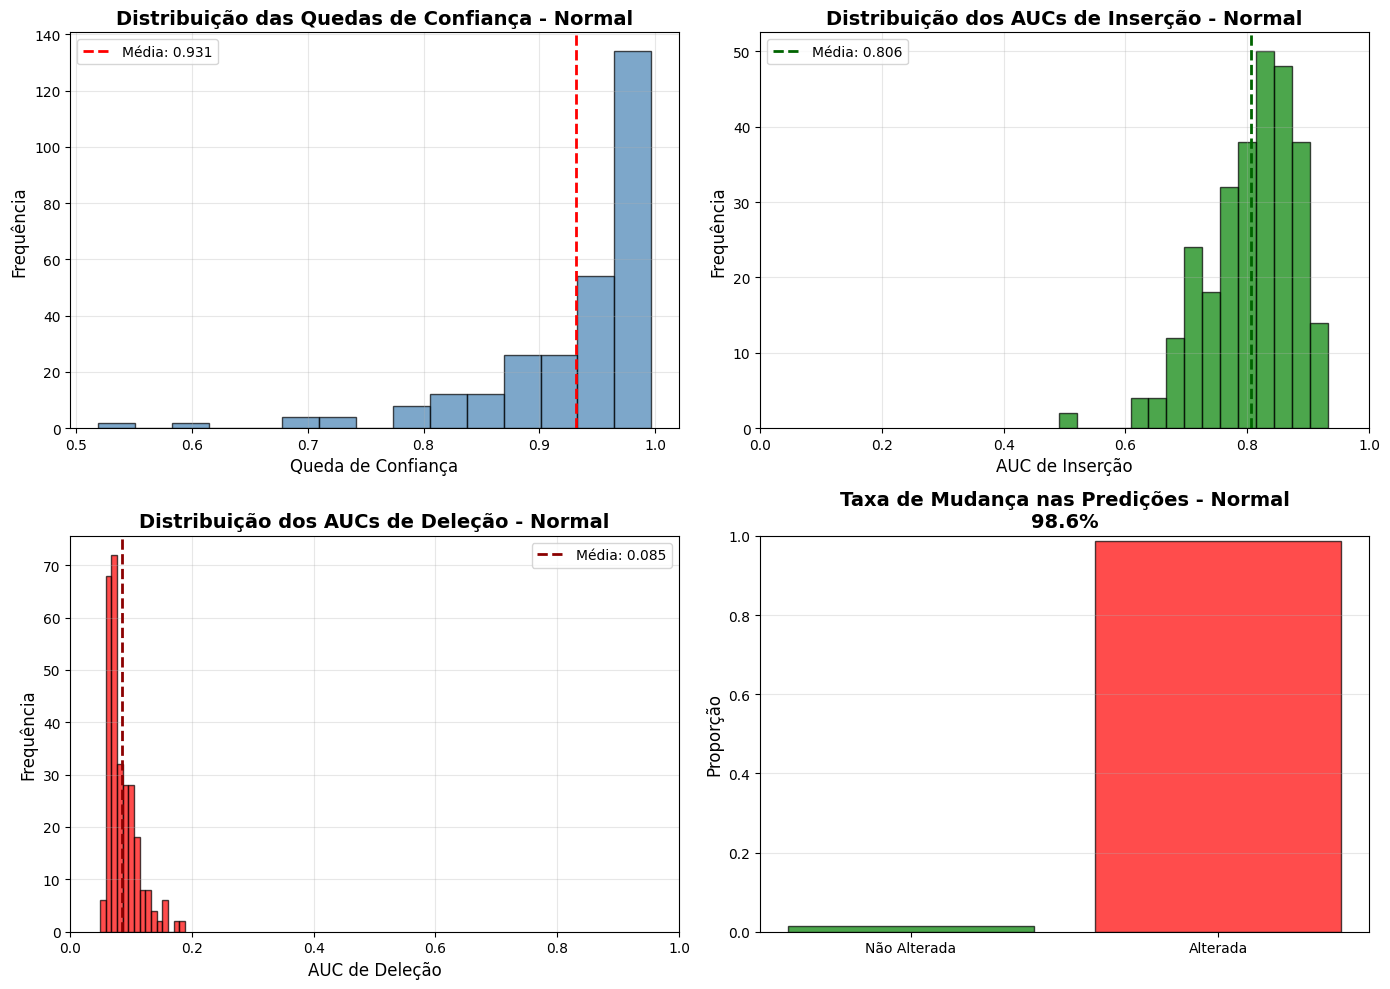


ESTATÍSTICAS PARA CLASSE: Normal
  Número de amostras: 284
  Queda de Confiança: 0.931 ± 0.079
  AUC Inserção: 0.806 ± 0.074
  AUC Deleção: 0.085 ± 0.025
  Taxa de Mudança: 98.6%



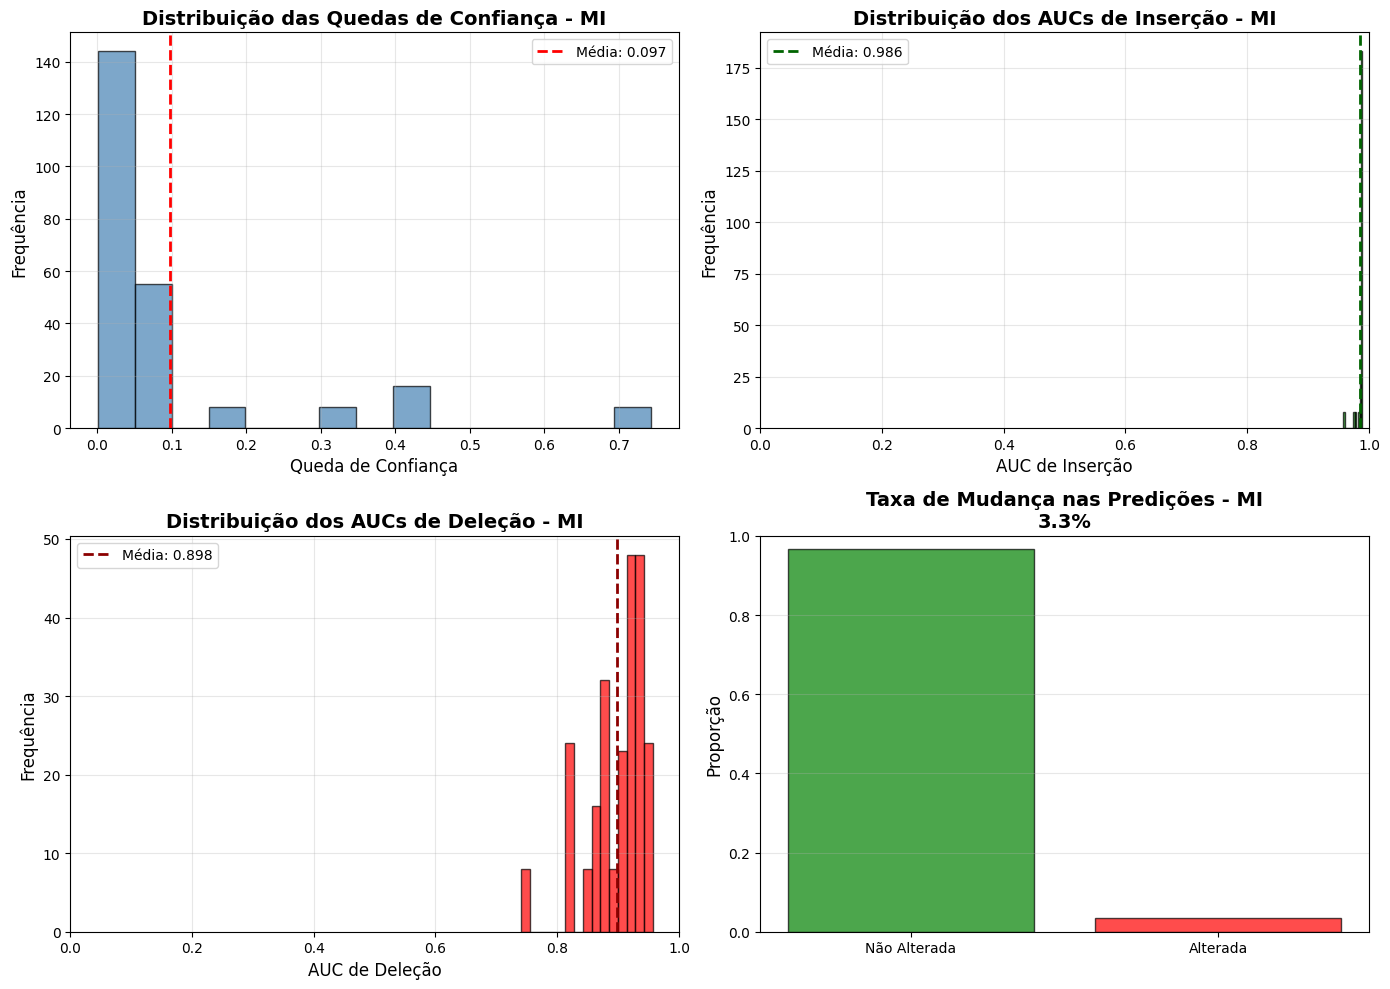


ESTATÍSTICAS PARA CLASSE: MI
  Número de amostras: 239
  Queda de Confiança: 0.097 ± 0.165
  AUC Inserção: 0.986 ± 0.006
  AUC Deleção: 0.898 ± 0.047
  Taxa de Mudança: 3.3%



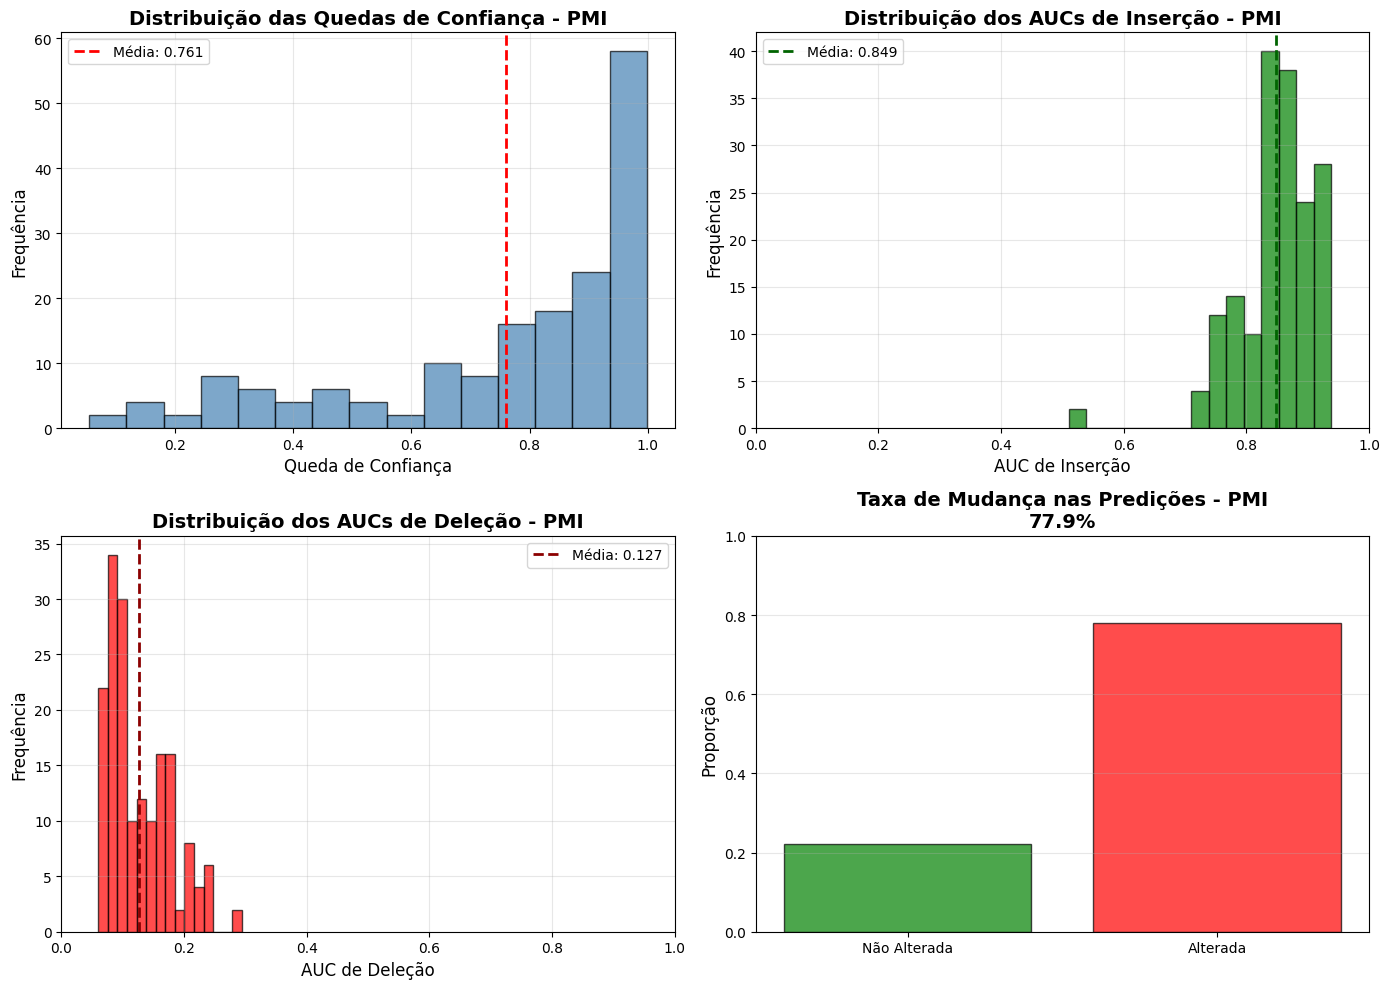


ESTATÍSTICAS PARA CLASSE: PMI
  Número de amostras: 172
  Queda de Confiança: 0.761 ± 0.250
  AUC Inserção: 0.849 ± 0.065
  AUC Deleção: 0.127 ± 0.052
  Taxa de Mudança: 77.9%



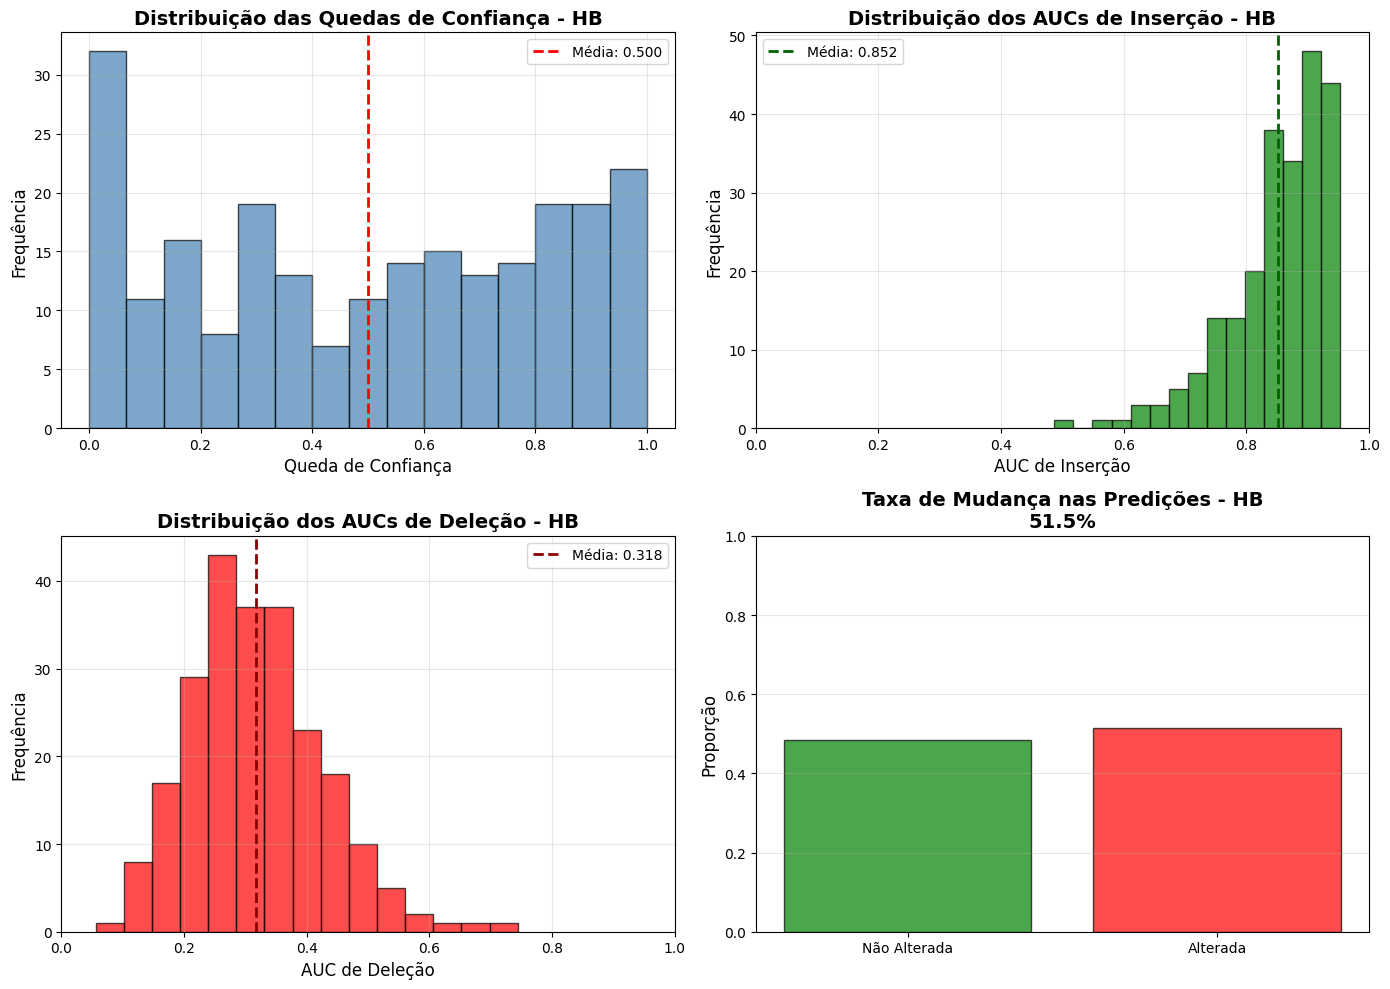


ESTATÍSTICAS PARA CLASSE: HB
  Número de amostras: 233
  Queda de Confiança: 0.500 ± 0.322
  AUC Inserção: 0.852 ± 0.080
  AUC Deleção: 0.318 ± 0.111
  Taxa de Mudança: 51.5%


✓ Figuras por classe salvas em: ../texto/figuras/validacao_estatistica_por_classe/


In [24]:
# plot per class analysis (same as before but for each class separately)

import os
os.makedirs('../texto/figuras/validacao_estatistica_por_classe/', exist_ok=True)

# Gerar gráficos para cada classe separadamente
for class_name in validation_results['labels_names'].unique():
    class_data = validation_results[validation_results['labels_names'] == class_name]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Quedas de confiança
    axes[0, 0].hist(class_data['confidence_drops'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(np.mean(class_data['confidence_drops']), color='red', 
                       linestyle='--', linewidth=2, label=f'Média: {np.mean(class_data["confidence_drops"]):.3f}')
    axes[0, 0].set_xlabel('Queda de Confiança', fontsize=12)
    axes[0, 0].set_ylabel('Frequência', fontsize=12)
    axes[0, 0].set_title(f'Distribuição das Quedas de Confiança - {class_name}', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # AUCs de inserção
    axes[0, 1].hist(class_data['insertion_aucs'], bins=15, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].axvline(np.mean(class_data['insertion_aucs']), color='darkgreen',
                       linestyle='--', linewidth=2, label=f'Média: {np.mean(class_data["insertion_aucs"]):.3f}')
    axes[0, 1].set_xlabel('AUC de Inserção', fontsize=12)
    axes[0, 1].set_ylabel('Frequência', fontsize=12)
    axes[0, 1].set_xlim([0, 1])
    axes[0, 1].set_title(f'Distribuição dos AUCs de Inserção - {class_name}', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUCs de deleção
    axes[1, 0].hist(class_data['deletion_aucs'], bins=15, edgecolor='black', alpha=0.7, color='red')
    axes[1, 0].axvline(np.mean(class_data['deletion_aucs']), color='darkred',
                       linestyle='--', linewidth=2, label=f'Média: {np.mean(class_data["deletion_aucs"]):.3f}')
    axes[1, 0].set_xlabel('AUC de Deleção', fontsize=12)
    axes[1, 0].set_ylabel('Frequência', fontsize=12)
    axes[1, 0].set_xlim([0, 1])
    axes[1, 0].set_title(f'Distribuição dos AUCs de Deleção - {class_name}', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Taxa de mudanças de predição
    change_rate = np.mean(class_data['prediction_changes'])
    axes[1, 1].bar(['Não Alterada', 'Alterada'], 
                   [1-change_rate, change_rate],
                   color=['green', 'red'], edgecolor='black', alpha=0.7)
    axes[1, 1].set_ylabel('Proporção', fontsize=12)
    axes[1, 1].set_title(f'Taxa de Mudança nas Predições - {class_name}\n{change_rate:.1%}', 
                        fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(f'../texto/figuras/validacao_estatistica_por_classe/validacao_{class_name}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Imprimir estatísticas para a classe
    print(f"\n{'='*70}")
    print(f"ESTATÍSTICAS PARA CLASSE: {class_name}")
    print(f"{'='*70}")
    print(f"  Número de amostras: {len(class_data)}")
    print(f"  Queda de Confiança: {np.mean(class_data['confidence_drops']):.3f} ± {np.std(class_data['confidence_drops']):.3f}")
    print(f"  AUC Inserção: {np.mean(class_data['insertion_aucs']):.3f} ± {np.std(class_data['insertion_aucs']):.3f}")
    print(f"  AUC Deleção: {np.mean(class_data['deletion_aucs']):.3f} ± {np.std(class_data['deletion_aucs']):.3f}")
    print(f"  Taxa de Mudança: {change_rate:.1%}")
    print(f"{'='*70}\n")

print(f"\n✓ Figuras por classe salvas em: ../texto/figuras/validacao_estatistica_por_classe/")